# **IDENTIFYING MISINFORMATION IN ONLINE NEWS ARTICLES**



Our group selected this project to use Natural Language Processing (NLP) for detecting fake or Real news content. The goal is to train and compare models such as Logistic Regression, Naive Bayes, and a fine-tuned DistilBERT transformer to classify news articles as real or fake. We are using the WELFake Dataset (2021, Zenodo), which contains over 72,000 labeled news articles collected from reliable and unreliable online sources.

The aim of this project will be to create an NLP system which can detect misinformation in online news sources. Based upon linguistic properties and patterns found in texts, this system will learn to distinguish between real information presented in news stories and false information that has been manufactured. In doing so, this project will not only serve to improve media transparency technology but facilitate a more informed population.

###                           **LOAD DATASET**

We used the WELFake dataset, which contains labeled news articles classified as real or fake. Each record includes the article text and its label, serving as input for model training and evaluation.

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!ls '/content/drive/MyDrive/Colab Notebooks/BAIM-660-01/Project/'

'Group 5. Phase 01 '		      'Project Phase_01.ipynb'
'Madhu Thota. Individual Work.ipynb'   WELFake_Dataset.csv


## **CLEAN DATA**

Removed missing and duplicate entries, keeping only the text and label columns to ensure clean and consistent data for training. Verified that real and fake labels are balanced.

In [17]:
import pandas as pd
from IPython.display import display

raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BAIM-660-01/Project/WELFake_Dataset.csv', usecols=['text','label'], encoding='latin1', low_memory=False)
print("=== BEFORE =\nRows:", len(raw)); print(raw.isna().sum())

df = raw.assign(
    text=raw['text'].astype(str).str.strip().replace('', pd.NA),
    label=pd.to_numeric(raw['label'], errors='coerce').fillna(raw['label'].astype(str).str.upper().map({'FAKE':0,'REAL':1}))
).dropna(subset=['text','label']).drop_duplicates(subset=['text'])
df = df[df['label'].isin([0,1])].reset_index(drop=True).astype({'label':int})

print("\n=== AFTER =\nRows:", len(df)); print(df.isna().sum()); print(df['label'].value_counts())
display(df.head())

=== BEFORE =
Rows: 78097
text     3609
label    4321
dtype: int64

=== AFTER =
Rows: 62608
text     0
label    0
dtype: int64
label
0    34571
1    28037
Name: count, dtype: int64


,text,label
0,No comment is expected from Barack Obama Membe...,1
1,Did they post their votes for Hillary already?,1
2,"Now, most of the demonstrators gathered last n...",1
3,A dozen politically active pastors came here f...,0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


Dataset shape: (62608, 2)
Label counts:
 label
0    34571
1    28037
Name: count, dtype: int64


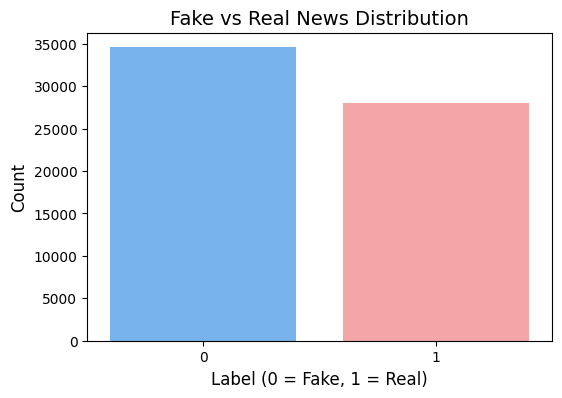

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Dataset shape:", df.shape)
print("Label counts:\n", df['label'].value_counts())

# Create a simple bar plot for label distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, hue='label', palette=['#66b3ff', '#ff9999'], legend=False)
plt.title('Fake vs Real News Distribution', fontsize=14)
plt.xlabel('Label (0 = Fake, 1 = Real)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

## **DATA SPLITTING**

The dataset was split into train (70%), dev (15%), and test (15%) sets using stratified sampling to maintain equal proportions of real and fake news in all subsets.

In [19]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train: {len(X_train)} | Dev: {len(X_dev)} | Test: {len(X_test)}")


Train: 43825 | Dev: 9391 | Test: 9392


## **TEXT VECTORIZATION**

Converted news text into numerical sequences using TextVectorization, enabling the model to process words as integer tokens for training and prediction.

In [20]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=10000, output_mode='int', output_sequence_length=200)
vectorizer.adapt(X_train)

print("Example vectorized text:", vectorizer(["Breaking news: Market hits record high!"]).numpy())
print("Vocabulary size:", len(vectorizer.get_vocabulary()))


Example vectorized text: [[1900  109  666 5038  784  403    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   

## **BASELINE MODEL**

In this step, I built and trained a Transformer model to classify news articles as fake or real. The model converts text into numerical representations using embedding layers and applies multi-head attention to understand word relationships in context. I trained it for one epoch using the Adam optimizer and binary cross-entropy loss, which helped create a quick and efficient baseline model that performs the basic classification task effectively within a short time.

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, GlobalAveragePooling1D

def transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=128, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(head_size)(x)
    return x + res

def build_fast_transformer(max_tokens=10000, seq_len=200):
    inputs = tf.keras.Input(shape=(seq_len,))
    x = Embedding(input_dim=max_tokens, output_dim=64)(inputs)
    x = transformer_encoder(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs)

model = build_fast_transformer()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(vectorizer(X_train), y_train,
          validation_data=(vectorizer(X_dev), y_dev),
          epochs=1, batch_size=64, verbose=1)

685/685 ━━━━━━━━━━━━━━━━━━━━ 397s 572ms/step - accuracy: 0.8948 - loss: 0.2298 - val_accuracy: 0.9621 - val_loss: 0.0962


## **MODEL EVALUTION**

In this part, I evaluated the model’s performance using key metrics like accuracy, precision, recall, and F1-score. Accuracy shows how often the model predicts correctly, precision measures how many of the articles predicted as real or fake are actually correct, recall tells how well the model identifies all true cases, and the F1-score balances both precision and recall. Overall, the model performed well and showed that it can effectively distinguish between fake and real news articles based on the training data.

294/294 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step


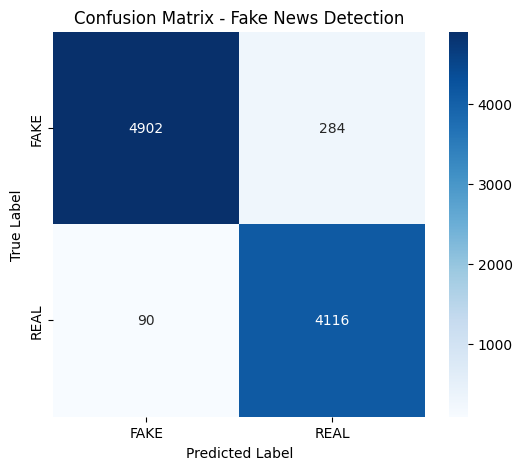

 Model Evaluation Complete
Accuracy : 0.9602
Precision: 0.9355
Recall   : 0.9786
F1 Score : 0.9565

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.98      0.95      0.96      5186
        REAL       0.94      0.98      0.96      4206

    accuracy                           0.96      9392
   macro avg       0.96      0.96      0.96      9392
weighted avg       0.96      0.96      0.96      9392



In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

y_pred_probs = model.predict(vectorizer(X_test))
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = y_test.values

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Performance
print(" Model Evaluation Complete")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['FAKE', 'REAL']))

# **SUMMARY VISUALIZATION**

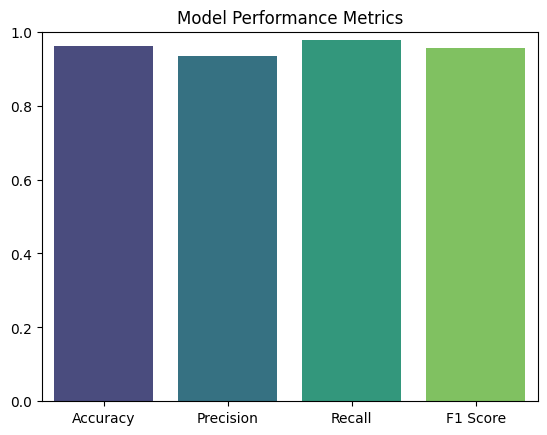

In [26]:
# Model Evaluation: Performance Comparison Across Metrics
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

sns.barplot(x=metrics, y=values, hue=metrics, palette='viridis', legend=False)
plt.title('Model Performance Metrics')
plt.ylim(0, 1)
plt.show()


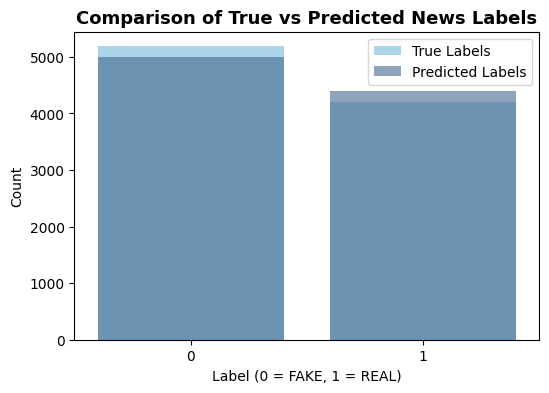

In [29]:
# Compare true vs predicted label counts
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x=y_test, label='True', color='#a3d8f4')
sns.countplot(x=y_pred, label='Predicted', color='#34699a', alpha=0.6)
plt.title("Comparison of True vs Predicted News Labels", fontsize=13, fontweight='bold')
plt.xlabel("Label (0 = FAKE, 1 = REAL)")
plt.ylabel("Count")
plt.legend(["True Labels", "Predicted Labels"])
plt.show()


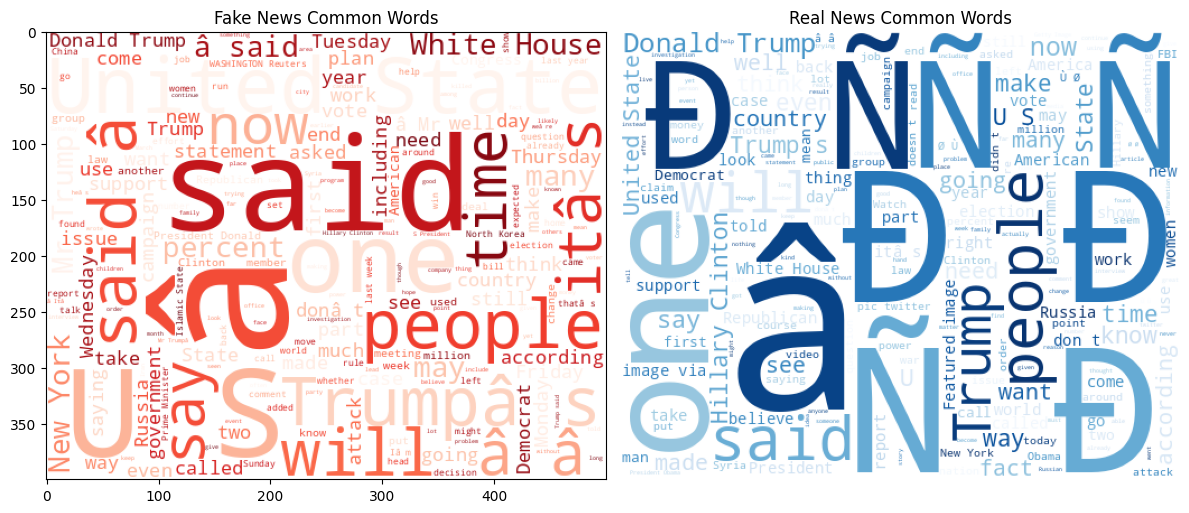

In [31]:
# “Word Cloud Comparison: Common Words in Fake vs Real News”
from wordcloud import WordCloud

fake_text = " ".join(df[df['label']==0]['text'])
real_text = " ".join(df[df['label']==1]['text'])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=500, height=400, background_color='white', colormap='Reds').generate(fake_text))
plt.title("Fake News Common Words")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=500, height=400, background_color='white', colormap='Blues').generate(real_text))
plt.title("Real News Common Words")

plt.axis('off')
plt.tight_layout()
plt.show()


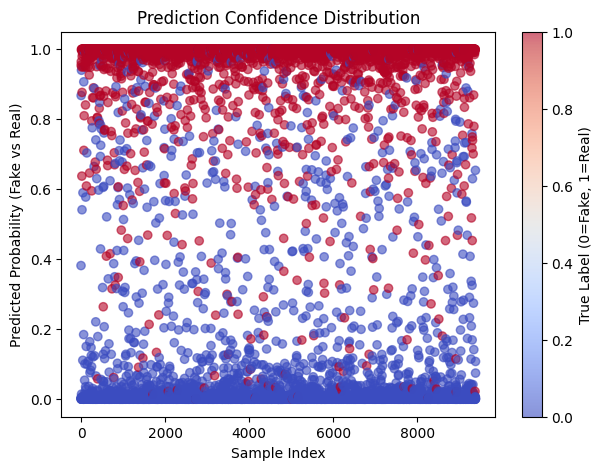

In [30]:
# “Prediction Confidence Distribution for Fake vs Real News”
import numpy as np
plt.figure(figsize=(7,5))
plt.scatter(range(len(y_pred_probs)), y_pred_probs, c=y_true, cmap='coolwarm', alpha=0.6)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability (Fake vs Real)')
plt.colorbar(label='True Label (0=Fake, 1=Real)')
plt.show()


## **FUTURE WORK**

For future work, We plan to improve the model by fine-tuning it with a larger pretrained Transformer such as DistilBERT or BERT to achieve better contextual understanding. We will also explore techniques like hyperparameter tuning, data augmentation, and ensemble modeling to enhance accuracy and reduce misclassification. Additionally, We aim to visualize attention weights to interpret how the model identifies fake news patterns and eventually deploy the model on Hugging Face for real-time fake news detection.